In [46]:
import struct
from datetime import datetime

In [108]:
def arfread1(PATH, **kwargs):
    # defaults
    PLOT = kwargs.get('PLOT', False)
    RP = kwargs.get('RP', False)
    
    isRZ = not RP
    
    data = {'RecHead': {}, 'groups': []}

    # open file
    with open(PATH, 'rb') as fid:
        # open RecHead data
        data['RecHead']['ftype'] = struct.unpack('h', fid.read(2))[0]
        data['RecHead']['ngrps'] = struct.unpack('h', fid.read(2))[0]
        data['RecHead']['nrecs'] = struct.unpack('h', fid.read(2))[0]
        data['RecHead']['grpseek'] = struct.unpack('200i', fid.read(4*200))
        data['RecHead']['recseek'] = struct.unpack('2000i', fid.read(4*2000))
        data['RecHead']['file_ptr'] = struct.unpack('i', fid.read(4))[0]

        data['groups'] = []
        bFirstPass = True
        for x in range(data['RecHead']['ngrps']):
            # jump to the group location in the file
            fid.seek(data['RecHead']['grpseek'][x], 0)

            # open the group
            data['groups'].append({
                'grpn': struct.unpack('h', fid.read(2))[0],
                'frecn': struct.unpack('h', fid.read(2))[0],
                'nrecs': struct.unpack('h', fid.read(2))[0],
                'ID': get_str(fid.read(16)),
                'ref1': get_str(fid.read(16)),
                'ref2': get_str(fid.read(16)),
                'memo': get_str(fid.read(50)),
            })

            # read temporary timestamp
            if bFirstPass:
                if isRZ:
                    ttt = struct.unpack('q', fid.read(8))[0]
                    fid.seek(-8, 1)
                    data['fileType'] = 'BioSigRZ'
                else:
                    ttt = struct.unpack('I', fid.read(4))[0]
                    fid.seek(-4, 1)
                    data['fileType'] = 'BioSigRP'
                data['fileTime'] = datetime.datetime.utcfromtimestamp(ttt/86400 + datetime.datetime(1970, 1, 1).timestamp()).strftime('%Y-%m-%d %H:%M:%S')
                bFirstPass = False

            if isRZ:
                grp_t_format = 'q'
                beg_t_format = 'q'
                end_t_format = 'q'
                read_size = 8
            else:
                grp_t_format = 'I'
                beg_t_format = 'I'
                end_t_format = 'I'
                read_size = 4

            data['groups'][x]['beg_t'] = struct.unpack(beg_t_format, fid.read(read_size))[0]
            data['groups'][x]['end_t'] = struct.unpack(end_t_format, fid.read(read_size))[0]

            data['groups'][x].update({
                'sgfname1': get_str(fid.read(100)),
                'sgfname2': get_str(fid.read(100)),
                'VarName1': get_str(fid.read(15)),
                'VarName2': get_str(fid.read(15)),
                'VarName3': get_str(fid.read(15)),
                'VarName4': get_str(fid.read(15)),
                'VarName5': get_str(fid.read(15)),
                'VarName6': get_str(fid.read(15)),
                'VarName7': get_str(fid.read(15)),
                'VarName8': get_str(fid.read(15)),
                'VarName9': get_str(fid.read(15)),
                'VarName10': get_str(fid.read(15)),
                'VarUnit1': get_str(fid.read(5)),
                'VarUnit2': get_str(fid.read(5)),
                'VarUnit3': get_str(fid.read(5)),
                'VarUnit4': get_str(fid.read(5)),
                'VarUnit5': get_str(fid.read(5)),
                'VarUnit6': get_str(fid.read(5)),
                'VarUnit7': get_str(fid.read(5)),
                'VarUnit8': get_str(fid.read(5)),
                'VarUnit9': get_str(fid.read(5)),
                'VarUnit10': get_str(fid.read(5)),
                'SampPer_us': struct.unpack('f', fid.read(4))[0],
                'cc_t': struct.unpack('i', fid.read(4))[0],
                'version': struct.unpack('h', fid.read(2))[0],
                'postproc': struct.unpack('i', fid.read(4))[0],
                'dump': get_str(fid.read(92)),
                'recs': [],
            })

            for i in range(data['groups'][x]['nrecs']):
                record_data = {
                        'recn': struct.unpack('h', fid.read(2))[0],
                        'grpid': struct.unpack('h', fid.read(2))[0],
                        'grp_t': struct.unpack(grp_t_format, fid.read(read_size))[0],
                        #'grp_d': datetime.utcfromtimestamp(data['groups'][x]['recs'][i]['grp_t']/86400 + datetime(1970, 1, 1).timestamp()).strftime('%Y-%m-%d %H:%M:%S'),
                        'newgrp': struct.unpack('h', fid.read(2))[0],
                        'sgi': struct.unpack('h', fid.read(2))[0],
                        'chan': struct.unpack('B', fid.read(1))[0],
                        'rtype': get_str(fid.read(1)),
                        'npts': struct.unpack('H' if isRZ else 'h', fid.read(2))[0],
                        'osdel': struct.unpack('f', fid.read(4))[0],
                        'dur_ms': struct.unpack('f', fid.read(4))[0],
                        'SampPer_us': struct.unpack('f', fid.read(4))[0],
                        'artthresh': struct.unpack('f', fid.read(4))[0],
                        'gain': struct.unpack('f', fid.read(4))[0],
                        'accouple': struct.unpack('h', fid.read(2))[0],
                        'navgs': struct.unpack('h', fid.read(2))[0],
                        'narts': struct.unpack('h', fid.read(2))[0],
                        'beg_t': struct.unpack(beg_t_format, fid.read(read_size))[0],
                        'end_t': struct.unpack(end_t_format, fid.read(read_size))[0],
                        'Var1': struct.unpack('f', fid.read(4))[0],
                        'Var2': struct.unpack('f', fid.read(4))[0],
                        'Var3': struct.unpack('f', fid.read(4))[0],
                        'Var4': struct.unpack('f', fid.read(4))[0],
                        'Var5': struct.unpack('f', fid.read(4))[0],
                        'Var6': struct.unpack('f', fid.read(4))[0],
                        'Var7': struct.unpack('f', fid.read(4))[0],
                        'Var8': struct.unpack('f', fid.read(4))[0],
                        'Var9': struct.unpack('f', fid.read(4))[0],
                        'Var10': struct.unpack('f', fid.read(4))[0],
                        'data': [] #list(struct.unpack(f'{data["groups"][x]["recs"][i]["npts"]}f', fid.read(4*data['groups'][x]['recs'][i]['npts'])))
                    }
                
                # skip all 10 cursors placeholders
                fid.seek(36*10, 1)
                record_data['data'] = list(struct.unpack(f'{record_data["npts"]}f', fid.read(4*record_data['npts'])))

                record_data['grp_d'] = datetime.datetime.utcfromtimestamp(record_data['grp_t'] / 86400 + datetime.datetime(1970, 1, 1).timestamp()).strftime('%Y-%m-%d %H:%M:%S')

                data['groups'][x]['recs'].append(record_data)

            if PLOT:
                import matplotlib.pyplot as plt

                # determine reasonable spacing between plots
                d = [x['data'] for x in data['groups'][x]['recs']]
                plot_offset = max(max(map(abs, [item for sublist in d for item in sublist]))) * 1.2

                plt.figure()

                for i in range(data['groups'][x]['nrecs']):
                    plt.plot([item - plot_offset * i for item in data['groups'][x]['recs'][i]['data']])
                    plt.hold(True)

                plt.title(f'Group {data["groups"][x]["grpn"]}')
                plt.axis('off')
                plt.show()

    return data

In [109]:
def get_str(data):
    # return string up until null character only
    ind = data.find(b'\x00')
    if ind > 0:
        data = data[:ind]
    try:
        return data.decode('utf-8')
    except UnicodeDecodeError:
        return data.decode('latin-1')

In [110]:
import numpy as np
import datetime
import matplotlib.pyplot as plt

def arfread2(PATH, **kwargs):
    PLOT = kwargs.get('PLOT', False)
    RP = kwargs.get('RP', False)

    isRZ = not RP

    data = {'RecHead': {}, 'groups': []}

    with open(PATH, 'rb') as fid:
        data['RecHead']['ftype'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
        data['RecHead']['ngrps'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
        data['RecHead']['nrecs'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
        data['RecHead']['grpseek'] = np.fromfile(fid, dtype=np.int32, count=200)
        data['RecHead']['recseek'] = np.fromfile(fid, dtype=np.int32, count=2000)
        data['RecHead']['file_ptr'] = np.fromfile(fid, dtype=np.int32, count=1)[0]

        data['groups'] = []
        bFirstPass = True

        for x in range(data['RecHead']['ngrps']):
            group = {}

            group['grpn'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
            group['frecn'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
            group['nrecs'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
            group['ID'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=16).astype('str'))
            group['ref1'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=16).astype('str'))
            group['ref2'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=16).astype('str'))
            group['memo'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=50).astype('str'))

            if bFirstPass:
                if isRZ:
                    ttt = np.fromfile(fid, dtype=np.int64, count=1)[0]
                    fid.seek(-8, 1)
                    data['fileTime'] = datetime.datetime.utcfromtimestamp(ttt / 86400 + datetime.datetime(1970, 1, 1).timestamp())
                    data['fileType'] = 'BioSigRZ'
                else:
                    ttt = np.fromfile(fid, dtype=np.uint32, count=1)[0]
                    fid.seek(-4, 1)
                    data['fileTime'] = datetime.datetime.utcfromtimestamp(ttt / 86400 + datetime.datetime(1970, 1, 1).timestamp())
                    data['fileType'] = 'BioSigRP'
                bFirstPass = False

            if isRZ:
                group['beg_t'] = np.fromfile(fid, dtype=np.int64, count=1)[0]
                group['end_t'] = np.fromfile(fid, dtype=np.int64, count=1)[0]
            else:
                group['beg_t'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
                group['end_t'] = np.fromfile(fid, dtype=np.int32, count=1)[0]

            group['sgfname1'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=100).astype('str'))
            group['sgfname2'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=100).astype('str'))

            group['VarName1'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName2'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName3'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName4'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName5'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName6'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName7'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName8'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName9'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))
            group['VarName10'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=15).astype('str'))

            group['VarUnit1'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit2'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit3'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit4'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit5'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit6'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit7'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit8'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit9'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))
            group['VarUnit10'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=5).astype('str'))

            group['SampPer_us'] = np.fromfile(fid, dtype=np.float32, count=1)[0]

            group['cc_t'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
            group['version'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
            group['postproc'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
            group['dump'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=92).astype('str'))

            group['recs'] = []
            for i in range(group['nrecs']):
                rec = {}

                rec['recn'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
                rec['grpid'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
                if isRZ:
                    rec['grp_t'] = np.fromfile(fid, dtype=np.int64, count=1)[0]
                else:
                    rec['grp_t'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
                rec['newgrp'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
                rec['sgi'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
                rec['chan'] = np.fromfile(fid, dtype=np.uint8, count=1)[0]
                rec['rtype'] = ''.join(np.fromfile(fid, dtype=np.uint8, count=1).astype('str'))

                rec['npts'] = np.fromfile(fid, dtype=np.uint16, count=1)[0] if isRZ else np.fromfile(fid, dtype=np.int16, count=1)[0]
                rec['osdel'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['dur_ms'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['SampPer_us'] = np.fromfile(fid, dtype=np.float32, count=1)[0]

                rec['artthresh'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['gain'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['accouple'] = np.fromfile(fid, dtype=np.int16, count=1)[0]

                rec['navgs'] = np.fromfile(fid, dtype=np.int16, count=1)[0]
                rec['narts'] = np.fromfile(fid, dtype=np.int16, count=1)[0]

                if isRZ:
                    rec['beg_t'] = np.fromfile(fid, dtype=np.int64, count=1)[0]
                    rec['end_t'] = np.fromfile(fid, dtype=np.int64, count=1)[0]
                else:
                    rec['beg_t'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
                    rec['end_t'] = np.fromfile(fid, dtype=np.int32, count=1)[0]

                rec['Var1'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var2'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var3'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var4'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var5'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var6'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var7'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var8'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var9'] = np.fromfile(fid, dtype=np.float32, count=1)[0]
                rec['Var10'] = np.fromfile(fid, dtype=np.float32, count=1)[0]

                fid.seek(36 * 10, 1)

                rec['data'] = np.fromfile(fid, dtype=np.float32, count=group['npts'])

                group['recs'].append(rec)

            data['groups'].append(group)

            if PLOT:
                plt.figure()

                plot_offset = max([max(abs(rec['data'])) for rec in group['recs']]) * 1.2

                for i, rec in enumerate(group['recs']):
                    plt.plot(rec['data'] - plot_offset * (i + 1))
                    plt.hold(True)

                plt.title('Group {}'.format(group['grpn']))
                plt.axis('off')

    return data


In [114]:
# Example usage:
#data = arfread1('ABR_ARF_files/471.arf', RP=True)
data = arfread1('ABR_ARF_files/Samp8 B1 baseline/1282_tone.arf', RP=False)
wave_data = []
for group in range(data['RecHead']['ngrps']):
    #this example has only 1 group
    print('group #', group)
    for rec in range(data['groups'][group]['nrecs']):
        # this one group has many recordings (different dBs, freqs)

        freq = data['groups'][group]['recs'][rec]['Var1']
        dB = data['groups'][group]['recs'][rec]['Var2']
        wave_data.append(data['groups'][0]['recs'][rec]['data'])

        gain = data['groups'][group]['recs'][rec]['gain'] # this might be where that 20x multiplier comes from? double check with elena
        total_t = data['groups'][group]['recs'][rec]['dur_ms']

        print('recording #',
                rec,
                'duration (ms)',
                total_t,
                'gain',
                gain,
                'Freq?',
                freq,
                'dB?',
                dB)

group # 0
recording # 0 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 90.0
recording # 1 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 85.0
recording # 2 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 80.0
recording # 3 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 75.0
recording # 4 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 70.0
recording # 5 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 65.0
recording # 6 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 60.0
recording # 7 duration (ms) 9.994239807128906 gain 20.0 Freq? 4000.0 dB? 55.0
recording # 8 duration (ms) 9.994239807128906 gain 20.0 Freq? 8000.0 dB? 90.0
recording # 9 duration (ms) 9.994239807128906 gain 20.0 Freq? 8000.0 dB? 85.0
recording # 10 duration (ms) 9.994239807128906 gain 20.0 Freq? 8000.0 dB? 80.0
recording # 11 duration (ms) 9.994239807128906 gain 20.0 Freq? 8000.0 dB? 75.0
recording # 12 duration (ms) 9.994239807128906 gain 

In [115]:
import pandas as pd
waves = pd.DataFrame(wave_data)

In [116]:
waves.iloc(axis=0)[0] * 1e6

0      0.000228
1      0.000799
2      0.001132
3      0.001134
4      0.000685
         ...   
239   -0.009504
240   -0.007313
241   -0.005110
242   -0.002847
243   -0.000243
Name: 0, Length: 244, dtype: float64

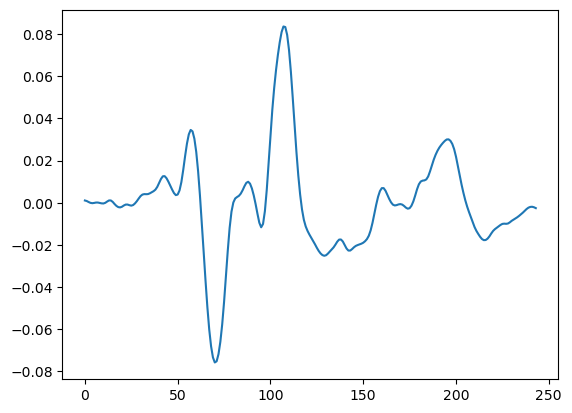

In [118]:
import matplotlib.pyplot as plt
plt.plot(waves.iloc(axis=0)[23] * 1e6)

In [120]:
data = arfread1('ABR_ARF_files/471.arf', RP=True)

rows = [] 
freqs = []
dbs = []

for group in data['groups']:
    for rec in group['recs']:

        freq = rec['Var1'] 
        freqs.append(freq)
        
        db = rec['Var2']
        dbs.append(db)
        
        wave_cols = list(enumerate(rec['data'])) 
        wave_data = {f'{i}':v*1e6 for i, v in wave_cols}
        
        # Construct row with freq & db first
        row = {'Freq(Hz)': freq, 'Level(dB)': db, **wave_data}
        
        rows.append(row)
        
waves = pd.DataFrame(rows) 

print(waves.head())

   Freq(Hz)  Level(dB)         0         1         2         3         4  \
0    5600.0       45.0  0.117030 -0.039093 -0.033656 -0.007645 -0.065616   
1    5600.0       50.0  0.333481 -0.147729 -0.114549 -0.039385  0.023559   
2    5600.0       55.0  0.659906  0.261300  0.235076  0.283933  0.283442   
3    5600.0       60.0  0.316031  0.350994  0.549153  0.426657  0.482044   
4    5600.0        0.0 -0.199800  0.549161  0.670640  0.628605  0.674283   

          5         6         7  ...        90        91        92        93  \
0 -0.095459 -0.065100 -0.069135  ...  0.128294  0.197274  0.158694  0.115665   
1  0.000749  0.004768  0.067141  ...  0.043084  0.066362  0.137526  0.181991   
2  0.256044  0.237637  0.136621  ...  0.205887  0.254619  0.237502  0.258778   
3  0.451893  0.380969  0.408875  ... -0.041582  0.014553  0.046494  0.112591   
4  0.475623  0.047097  0.381806  ... -0.230908 -0.007539  0.285824  0.399624   

         94        95        96        97        98        99 

In [139]:
import os

# Folder path
folders = ['ABR_ARF_files/Samp8 9moF 24h PSI', 'ABR_ARF_files/Samp8 A1 24h PSI', 'ABR_ARF_files/Samp8 A1 baseline', 'ABR_ARF_files/Samp8 A2 1wk PSI', 'ABR_ARF_files/Samp8 A2 24h PSI', 'ABR_ARF_files/Samp8 A2 baseline', 'ABR_ARF_files/Samp8 B1 24 h PSI', 'ABR_ARF_files/Samp8 B1 baseline', 'ABR_ARF_files/Samp8 B2 1 week PSI', 'ABR_ARF_files/Samp8 B2 24h', 'ABR_ARF_files/Samp8 B2 baseline', 'ABR_ARF_files/Samp8 C1 1 week JRT', 'ABR_ARF_files/Samp8 C1 24 h JRT', 'ABR_ARF_files/Samp8 C1 baseline', 'ABR_ARF_files/Samp8 C2 baseline', 'ABR_ARF_files/Samp8 C2 JRT 24 h', 'ABR_ARF_files/Samp8 Female 24 h PSI', 'ABR_ARF_files/Samp8 Female baseline', 'ABR_ARF_files/Samp8 Fgroup2 1 week PSI', 'ABR_ARF_files/Samp8 Fgroup4 baseline', 'ABR_ARF_files/Samp8 Fgroup5 baseline', 'ABR_ARF_files/Samp8 MFgroup4 24 h PSI', 'ABR_ARF_files/Samp8 Mgroup3  baseline', 'ABR_ARF_files/Samp8 Mgroup3 24 h PSI', 'ABR_ARF_files/Samp8 Mgroup4 baseline']

# Loop through ARF files
for folder in folders:
    for filename in os.listdir(folder):
        prefix = folder.split(' ')[1]
        suffix = ' '.join(folder.split(' ')[2:])
        if filename.endswith('.arf'): 
            
            file_path = os.path.join(folder, filename)
            
            # Read ARF 
            data = arfread(file_path)  
            
            # Extract data into rows 
            rows = []
            for group in data['groups']:
                for rec in group['recs']: 
                    freq = rec['Var1']  
                    db = rec['Var2']
                    wave_data = {f'{i}':v*1e6 for i, v in enumerate(rec['data'])}
                    
                    row = {'Freq(Hz)': freq, 
                        'Level(dB)': db,
                        **wave_data}
                    
                    rows.append(row)
        
            # Create DataFrame  
            df = pd.DataFrame(rows)
            
            # Write to CSV
            out_path = f"ABR_exported_files/{prefix}_{filename.replace('.arf', '')} {suffix}.csv" 
            df.to_csv(out_path, index=False)
        
print('Done processing folder')

Done processing folder
